In [1]:
import pandas as pd
from fastai.tabular.data import FillMissing, Normalize, Categorify
from fastai.tabular.data import TabularPandas
from pathlib import Path
from ams.config import constants
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Miniconda3\envs\alpha_media_signal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
parent_path = Path(constants.OVERFLOW_DATA_PATH, "twitter", "inference_model_drop")
file_path_str = str(Path(parent_path, "train_ready_tweets.csv"))

df_train_red = pd.read_csv(file_path_str)

In [3]:
%%time

def get_bools(df: pd.DataFrame):
    return [c for c in df.columns if str(df[c].dtype) == "bool"]
    
df_con = df_train_red.sample(frac=.5)

# for b in get_bools(df_con):
#     df_con[b] = df_con[b].astype('float64')

Wall time: 5.49 s


In [76]:
df_column_filter = df_con
cols = sorted(list(df_column_filter.columns))# [:109]

cont_name_new = []
col_short_list = []
col_numeric = []
for c in cols:
    dtype_str = str(df_column_filter[c].dtype)
    if not c.startswith("location_")\
    and not c.startswith("famaindustry_")\
    and not c.startswith("category_")\
    and not c.startswith("currency_")\
    and not c.startswith("industry_"):
        col_short_list.append(c)
        if dtype_str not in ["bool", "object"]:
            cont_name_new.append(c)
        if dtype_str in ["float64", "float32", "int64"]:
            col_numeric.append(c)

df_column_filter = df_column_filter[col_short_list]

col_dirty = ["future_high", "future_low", "future_close", "future_open", "future_date", 
             "f22_ticker", "purchase_date", "date", "user_screen_name", "stock_val_change", 
             "f22_num_other_tickers_in_tweet", "user_follow_request_sent"]

col_clean = list(set(col_numeric) - set(col_dirty))

y_names = ["buy_sell"]

cont_names = list(set(col_clean) - set(y_names))

# print(col_short_list)

In [77]:
from ams.services import twitter_service
use_recent_for_holdout = True

df_rem, df_val = twitter_service.ho_split_by_days(df_column_filter, 
                                                        small_data_days_to_pull=None, 
                                                        small_data_frac=.025, 
                                                        use_only_recent_for_holdout=use_recent_for_holdout)

df_big, df_test = twitter_service.ho_split_by_days(df_rem, 
                                                        small_data_days_to_pull=None, 
                                                        small_data_frac=.2, 
                                                        use_only_recent_for_holdout=use_recent_for_holdout)

df_big = twitter_service.balance_df(df_big)
df_test = twitter_service.balance_df(df_test)

Split | min: 2020-08-10 | max: 2020-10-20
Split dates for small dataset: ['2020-10-19', '2020-10-20']
Split | min: 2020-08-10 | max: 2020-10-16
Split dates for small dataset: ['2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16']


In [119]:
from fastai.tabular.data import CategoryBlock
from fastcore.foundation import L
from fastai.tabular.data import Categorify, noop

procs = [FillMissing, Categorify, Normalize]

with pd.option_context('mode.chained_assignment', None):
    df_test["is_train"] = False
    df_big["is_train"] = True

print("About to concat ...")
df_tog = pd.concat([df_test, df_big], axis=0)

df_tog["close_SMA_100"] = df_tog["close_SMA_100"].fillna(999999)
df_tog["close_SMA_20"] = df_tog["close_SMA_20"].fillna(999999)
df_tog["close_SMA_15"] = df_tog["close_SMA_15"].fillna(999999)
df_tog["close_SMA_50"] = df_tog["close_SMA_50"].fillna(999999)

df_tog.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

print("About to split ...")
test_split = df_tog[df_tog["is_train"] == False].index.tolist()
train_split = df_tog[df_tog["is_train"] == True].index.tolist()

train_split = L(train_split)
test_split = L(test_split)
splits = (train_split, test_split)

cont_names_short = cont_names #[:185]

# for i in range(120, 151):
#     items = df_tog[cont_names[i]].unique().tolist()
#     print(f"{cont_names[i]}: {items}")
# cont_names_short = list(set(cont_names_short + cont_names[-25:]))
# print(cont_names[140:146])

cont_names_short.remove('famasector')

print("About to create tabular pandas ...")
to = TabularPandas(df_tog, cat_names=[], cont_names=cont_names_short, procs=procs, splits=splits, y_names="buy_sell", y_block=CategoryBlock())

print("About to create dataloader ...")
dls = to.dataloaders(bs=64, device='cuda')
print("Created dataloader.")

print(f"Num features: {df_tog.shape[1]}")

About to concat ...
About to split ...
About to create tabular pandas ...
About to create dataloader ...
Created dataloader.
Num features: 204


In [130]:
from fastai.tabular.learner import tabular_learner, accuracy, ranger, rmse

num_features = df_tog.shape[1]

layers=[num_features, num_features + 10]
# layers=[10, 5]
learn = tabular_learner(dls, layers=layers, metrics=accuracy)

In [131]:
learn.model_dir = str(parent_path)
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=7.585775847473997e-07)

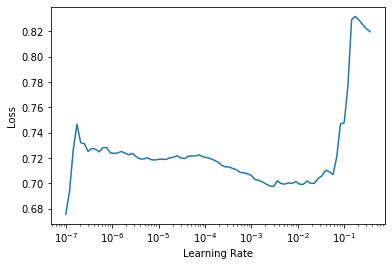

In [132]:
from fastai.callback.schedule import lr_find
sug_lrs = lr_find(learn)
sug_lrs

In [133]:
from fastai.callback import tracker as t

# callbacks = [
#     t.EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
#     t.SaveModelCallback(learn)
# ]

epochs = 5
learn.fit_one_cycle(epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.358434,4.671789,0.470902,00:49
1,0.262511,1110.229980,0.489536,00:48
2,0.225199,5315.864746,0.457928,00:50
3,0.206723,10272.921875,0.458567,00:50
4,0.195498,12082.486328,0.478099,00:49


In [ ]:
import numpy as np
from statistics import mean
from ams.utils.Stopwatch import Stopwatch

df_bal_val = twitter_service.balance_df(df_val)

print(df_tog[df_tog["buy_sell"] == -1].shape[0])
print(df_tog[df_tog["buy_sell"] == 1].shape[0])

df_g_holdout = df_val.groupby(['f22_ticker', 'purchase_date'])

stopwatch = Stopwatch(start_now=True)
all_date_preds = []
acc_acc = []
for group_name, df_group in df_g_holdout:
    ticker = group_name[0]
    pur_dt_str = group_name[1]
    y_holdout = np.array(df_group['buy_sell'])
    y_holdout = np.where(y_holdout==-1, 0, y_holdout)
    ticker_probs = []
    for i in range(df_group.shape[0]):
        row, clas, probs = learn.predict(df_group.iloc[i])
        prob_np = probs.numpy().tolist()
#         print(f"ticker: {ticker}: prob_np: {prob_np}; clas: {clas}")
        ticker_probs.append(prob_np[1])
    pre_y_ho = sum(y_holdout)/len(y_holdout)
    
    pre_y_ho = 0 if pre_y_ho < .5 else 1
    pred_mean = mean(ticker_probs)
    pred_mean = 0 if pred_mean < .5 else 1
#     print(f"{pre_y_ho}: {pred_mean}")
    all_date_preds.append(pred_mean)
    pred_buy_success = 0
    if pred_mean == 1:
        if pre_y_ho == pred_mean:
            pred_buy_success = 1

        # Of the buys what's is the success rate?
#         print(f"Positive ROI on ticker {ticker} trade on day {pur_dt_str}? {pred_buy_success == 1}")
        acc_acc.append(pred_buy_success)
    
all_pred_mean = mean(all_date_preds)
if len(acc_acc) == 0:
    print("No buy predictions.")
else:
    print(f"Mean Acc: {mean(acc_acc)}")

# print(row)
# print(clas)
# print(probs)
stopwatch.end(msg="Mean calculation")

247543
247543


In [18]:
print(len(acc_acc))

8


In [ ]:
def group_and_mean_preds(df: pd.DataFrame, learner: object, train_cols: List[str], is_model_torch=False):
    df_g_holdout = df.groupby(['f22_ticker', 'purchase_date'])

    group_count = 0
    acc_acc = []
    group_preds = {}
    for group_name, df_group in df_g_holdout:
        X_holdout = np.array(df_group[train_cols])
        y_holdout = np.array(df_group['buy_sell'])
        
        if is_model_torch:
            X_holdout_con = X_holdout.astype(desired_dtype)
            X_torch = torch.FloatTensor(X_holdout_con)
            
            y_holdout = np.where(y_holdout==-1, 0, y_holdout)
            pre_y_ho = sum(y_holdout)/len(y_holdout)
            pre_y_ho = 0 if pre_y_ho < .5 else 1
            
            model.eval()

            with torch.no_grad():
                model.cpu()
                raw_out = model(X_torch)
            
            prediction = raw_out.data.numpy()
            y_pred_tag = torch.round(torch.sigmoid(raw_out.data))
            pred_mean = sum(y_pred_tag.numpy()) / len(y_holdout)

            pred_mean = -1 if pred_mean < .5 else 1
        else:
            prediction = model.predict(X_holdout)

            pred_mean = sum(prediction)/len(prediction)
            pred_mean = -1 if pred_mean < 0 else 1

            pre_y_ho = sum(y_holdout)/len(y_holdout)
            pre_y_ho = -1 if pre_y_ho < 0 else 1

        # NOTE: This means that we are predicting only when buys are successfull. And we only buy.
        pred_buy_success = 0
        if pred_mean == 1:
            if pre_y_ho == pred_mean:
                pred_buy_success = 1
            
            # Of the buys what's is the success rate?
            acc_acc.append(pred_buy_success)

        ticker = group_name[0]
        date_str = group_name[1]
        if ticker in group_preds.keys():
            info = group_preds[ticker]
        else:
            info = {}
            group_preds[ticker] = info
        info[date_str] = pred_mean

    if len(acc_acc) > 0:
        print(f"Mean: {mean(acc_acc)}")
    else:
        print("No mean on grouped mean - no rows?")

    g_tickers = []
    for group_name, df_group in df_g_holdout:
        g_tickers.append(group_name[0])
    
    return g_tickers, group_preds

In [ ]:


scores = [.0096,
              .0081,
              .0075,
              .0073,
              .0072,
              .011,
              .0058,
              .0038,
              .0004,
              -.00058,
              .00049,
              -0.00058,
              .0017,
              -0.0032,
              -0.0010,
              -0.0074,
              -0.0043,
              -0.00086,
              0.00011,
              0.0016,
              0.0057,
              0.00600910,
              0.006631,
              0.0097,
              0.004403,
              -0.0087,
              -0.02477,
              -0.0174,
              0.00129,
              0.009,
              0.00435,
              -0.0011339,
              -.00549,
              -0.000864,
              0.000719,
              -0.00191,
              0.0053135,
              -0.00303,
              0.01231,
              -0.00120]

import pandas as pd
df = pd.DataFrame(scores, columns=["score"])

# print(df.columns)
# df.drop("foo", inplace=True, axis=1)
# df["score"] = scores

from statistics import mean
print(mean(scores))

df["row"] = df.index

import seaborn as sns
import numpy as np

sns.set_theme()
# np.random.seed(0)
# x = np.random.randn(100)
ax = sns.histplot(scores)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df["row"].values, list(reversed(scores)))